# Data

The data is downloaded from NATIONAL CENTRE FOR POLAR AND OCEAN RESEARCH, India: http://data.ncaor.gov.in/newhtml

# Dataset Info

In [1]:
with open('b_imdncpor_synoptic.txt') as f:
    print(' '.join(f.readlines()))


 ----------------------Synoptic Data-------------------------------------------------------------------
 
 Measurements/ data	: Synoptic
 Parameters		: Observation Time,  wind direction, wind speed, temparature, MSLP
 Duration		: 05-05-2016 to	02-08-2021
 Location		: Bharati
 Latitude and Longitude	: 69Â°24.41'S, 76Â°11.72'E
 Data file format	: ASCII
 
 ------------------------------------------------------------------------------------------------------
 
 
 



In [85]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('synoptic_bharati.csv')
df.Time = pd.to_datetime(df.Time)
df.head()

,Time,WindDirection,WindSpeed,Temperature,Pressure
0,2016-05-01 00:00:00,5,8.0,-21.5,981.1
1,2016-05-22 00:00:00,0,0.0,-19.4,986.1
2,2016-05-22 06:00:00,9,10.0,-16.6,980.4
3,2016-05-22 12:00:00,9,9.0,-17.4,973.4
4,2016-05-22 18:00:00,5,13.0,-17.4,970.7


In [4]:
df.isna().sum()

Time               0
WindDirection      0
WindSpeed        107
Temperature       16
Pressure         362
dtype: int64

In [5]:
min_time = df.Time.min()
max_time = df.Time.max()
weather_data = pd.DataFrame(pd.date_range(min_time,max_time, freq='6H'), columns=['Time'])
weather_data.head()

,Time
0,2016-05-01 00:00:00
1,2016-05-01 06:00:00
2,2016-05-01 12:00:00
3,2016-05-01 18:00:00
4,2016-05-02 00:00:00


https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html

In [6]:
weather_data = pd.merge(weather_data, df, on='Time', how='left')
weather_data.isna().sum()

Time                0
WindDirection    1906
WindSpeed        2013
Temperature      1922
Pressure         2268
dtype: int64

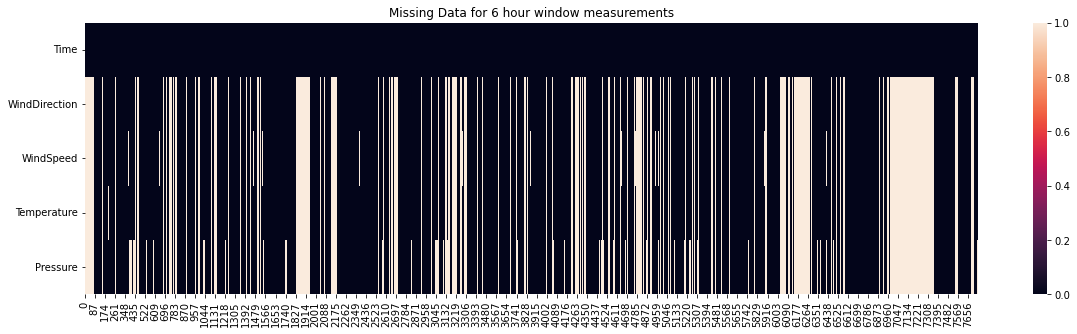

In [7]:
plt.figure(figsize=(20,5))
plt.title('Missing Data for 6 hour window measurements')
sns.heatmap(weather_data.isna().T)
plt.show()

We can observe that there is a significant period of time where there are missing values, especially around loc 1914, 6177, 7047 etc..

One idea is to impute data from nearby stations after analysis, but unfortunately there were no data available from the website. I emailed them hoping to get another dataset in from same location.

In the mean time, we can trim out the begining and last portions where log of missing values are there. 
So we take data from only 2715:6000

In [8]:
weather_data = weather_data.loc[2715:6000] # Through manual inspection and checking
weather_data.isna().sum()

Time               0
WindDirection    582
WindSpeed        635
Temperature      582
Pressure         794
dtype: int64

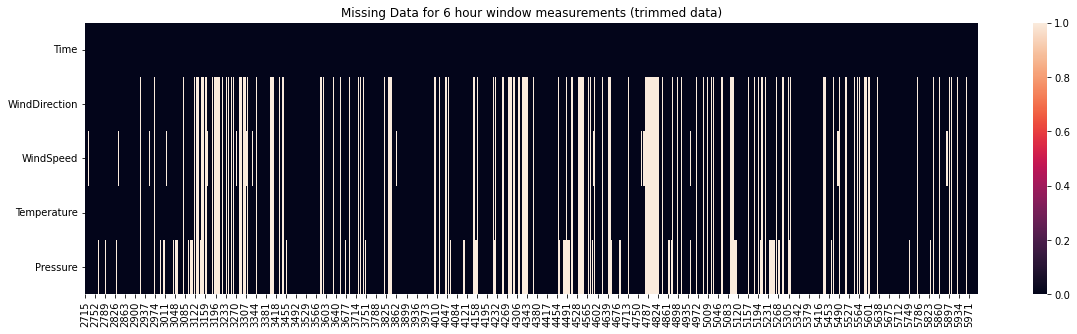

In [9]:
plt.figure(figsize=(20,5))
plt.title('Missing Data for 6 hour window measurements (trimmed data)')
sns.heatmap(weather_data.isna().T)
plt.show()

In [10]:
weather_data.index = weather_data.Time
weather_data.drop(['Time'], axis=1, inplace=True)
weather_data.index.max(), weather_data.index.min(), weather_data.index.max() - weather_data.index.min()

(Timestamp('2020-06-09 00:00:00'),
 Timestamp('2018-03-10 18:00:00'),
 Timedelta('821 days 06:00:00'))

We won't impute this data now. We ignore the continuity when we are treating it as a machine learning problem. Once we create the train and test pairs, we will drop the pairs which have nan values in the X, y pairs.

We can also try to use a random based splitting cv model to predict the in between points and impute the missing data, and a time based splitting cv model on the imputed data to predict for future days.

In [11]:
weather_data

,WindDirection,WindSpeed,Temperature,Pressure
Time,,,,
2018-03-10 18:00:00,9.0,19.0,-14.6,992.2
2018-03-11 00:00:00,11.0,16.0,-17.2,992.2
2018-03-11 06:00:00,9.0,9.0,-14.0,989.2
2018-03-11 12:00:00,9.0,14.0,-15.5,986.2
2018-03-11 18:00:00,7.0,18.0,-16.8,984.4
...,...,...,...,...
2020-06-08 00:00:00,5.0,5.0,-9.6,981.7
2020-06-08 06:00:00,5.0,8.0,-10.0,980.5
2020-06-08 12:00:00,11.0,4.0,-11.5,977.7


Using Temperature data to forecast future temperature.

In [19]:
temp_df = weather_data[['Temperature']].copy()
temp_df.head()

,Temperature
Time,
2018-03-10 18:00:00,-14.6
2018-03-11 00:00:00,-17.2
2018-03-11 06:00:00,-14.0
2018-03-11 12:00:00,-15.5
2018-03-11 18:00:00,-16.8


In [24]:
temp_df.describe()

,Temperature
count,2704.000000
mean,-9.463277
std,7.216770
min,-33.000000
25%,-14.600000
50%,-9.300000
75%,-3.800000
max,6.000000


In [25]:
temp_df.isna().sum()

Temperature    582
dtype: int64

In [36]:
pd.concat((temp_df.isna().T,temp_df.T), axis=0)

Time,2018-03-10 18:00:00,2018-03-11 00:00:00,2018-03-11 06:00:00,2018-03-11 12:00:00,2018-03-11 18:00:00,2018-03-12 00:00:00,2018-03-12 06:00:00,2018-03-12 12:00:00,2018-03-12 18:00:00,2018-03-13 00:00:00,...,2020-06-06 18:00:00,2020-06-07 00:00:00,2020-06-07 06:00:00,2020-06-07 12:00:00,2020-06-07 18:00:00,2020-06-08 00:00:00,2020-06-08 06:00:00,2020-06-08 12:00:00,2020-06-08 18:00:00,2020-06-09 00:00:00
Temperature,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
Temperature,-14.6,-17.2,-14.0,-15.5,-16.8,-16.5,-15.1,NaN,-17.0,-17.3,...,-8.4,-8.8,-8.9,-8.9,-9.4,-9.6,-10.0,-11.5,-7.9,-6.4


[]

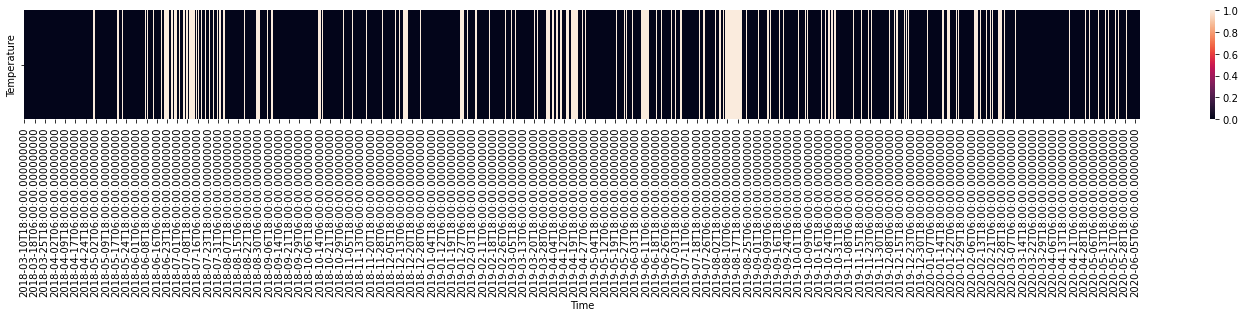

In [41]:
plt.figure(figsize=(25,2))
sns.heatmap(temp_df.isna().T)
plt.plot()

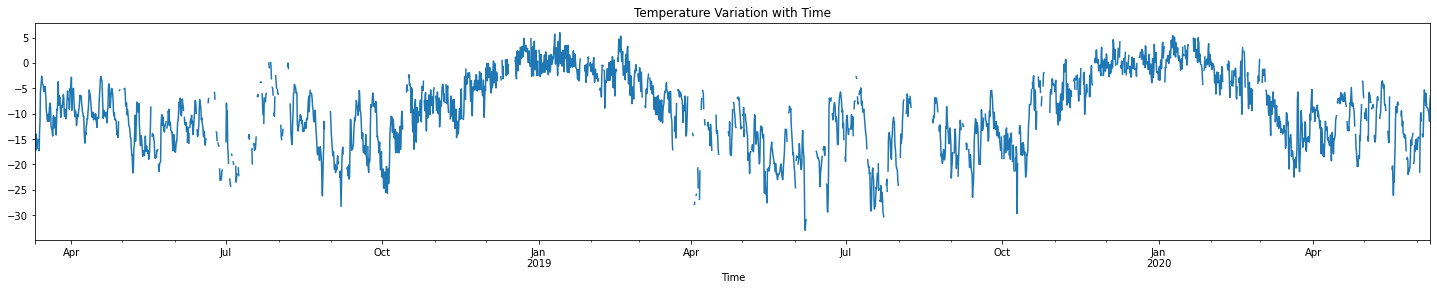

In [52]:
weather_data.Temperature.plot(figsize=(25,4), title='Temperature Variation with Time')
plt.show()

We can see highest temperature around january and lowet temperatures around July to October.

In [81]:

def simple_x_y_splitter(dataframe, col, prev_n_days=5):
    df = dataframe.copy()
    for lag in range(1, prev_n_days+1):
        df[f'lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)
    y = df[col].values
    X = df.drop([col], axis=1).values
    return np.expand_dims(X,2), y

In [82]:
X, y = simple_x_y_splitter(temp_df, 'Temperature',5)

In [83]:
y

array([-16.5, -15.1,  -4.7, ..., -11.5,  -7.9,  -6.4])

In [84]:
X

array([[[-16.8],
        [-15.5],
        [-14. ],
        [-17.2],
        [-14.6]],

       [[-16.5],
        [-16.8],
        [-15.5],
        [-14. ],
        [-17.2]],

       [[ -5.9],
        [-11.7],
        [-13.4],
        [-17.3],
        [-17. ]],

       ...,

       [[-10. ],
        [ -9.6],
        [ -9.4],
        [ -8.9],
        [ -8.9]],

       [[-11.5],
        [-10. ],
        [ -9.6],
        [ -9.4],
        [ -8.9]],

       [[ -7.9],
        [-11.5],
        [-10. ],
        [ -9.6],
        [ -9.4]]])

# Temporal splitting

In [98]:
train_cv_split_idx, cv_test_split_idx = int(X.shape[0]*.7), int(X.shape[0]*.85)
print(train_cv_split_idx, cv_test_split_idx)
X_train, y_train = X[:train_cv_split_idx], y[:train_cv_split_idx]
X_cv, y_cv = X[train_cv_split_idx:cv_test_split_idx], y[train_cv_split_idx:cv_test_split_idx]
X_test, y_test = X[cv_test_split_idx:], y[cv_test_split_idx:]

1284 1559
